<a href="https://colab.research.google.com/github/Bast-94/ASL-PW/blob/main/TP_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self, latent_dim: int = 50,hidden_dim:int =400):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, hidden_dim)
        self.latent_dim = latent_dim
        self.fc21 = nn.Linear(hidden_dim, self.latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(hidden_dim, self.latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(self.latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
def train_vae(vae: VAE,optimizer, train_loader,n_epochs=10,loss_function =loss_function):

  for epoch in tqdm(range(n_epochs)):
      vae.train()
      train_loss = 0
      for data, _ in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch, mu, logvar = vae(data)
          loss = loss_function(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

      print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

100%|██████████| 9912422/9912422 [00:00<00:00, 110393136.88it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 129973920.41it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28510674.75it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23063594.15it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [2]:
vae(next(iter(train_loader))[0])[0].size()

torch.Size([128, 784])

In [10]:
next(iter(train_loader))[0].size()

torch.Size([128, 1, 28, 28])

## Exercices

* Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.
* Changer la dimension de l'espace latent.
* Changer l'architecture du VAE.
* Paramétrer la fonction loss pour pondérer les deux termes (reconstruction et régularisation).
* Optionnel : entraîner le modèle sur un autre dataset.

### Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_vae(vae,optimizer,train_loader=train_loader)

 10%|█         | 1/10 [00:16<02:26, 16.31s/it]

Epoch 0, Loss: 169.3484083984375


 20%|██        | 2/10 [00:28<01:49, 13.63s/it]

Epoch 1, Loss: 126.1822984375


 30%|███       | 3/10 [00:39<01:28, 12.66s/it]

Epoch 2, Loss: 117.01942828776042


 40%|████      | 4/10 [00:51<01:13, 12.19s/it]

Epoch 3, Loss: 112.9203798828125


 50%|█████     | 5/10 [01:03<01:00, 12.19s/it]

Epoch 4, Loss: 110.62550662434896


 60%|██████    | 6/10 [01:14<00:47, 11.98s/it]

Epoch 5, Loss: 109.13974318033854


 70%|███████   | 7/10 [01:26<00:35, 11.90s/it]

Epoch 6, Loss: 108.15499861653646


 80%|████████  | 8/10 [01:38<00:23, 11.85s/it]

Epoch 7, Loss: 107.40741236979167


 90%|█████████ | 9/10 [01:50<00:11, 11.83s/it]

Epoch 8, Loss: 106.85402841796875


100%|██████████| 10/10 [02:01<00:00, 12.17s/it]

Epoch 9, Loss: 106.36814614257813


In [4]:
def sample_from_latent_space(vae: VAE, z=None):
  if(z is None):
    z = torch.randn(vae.latent_dim)
  return vae.decode(z).view(28,28)

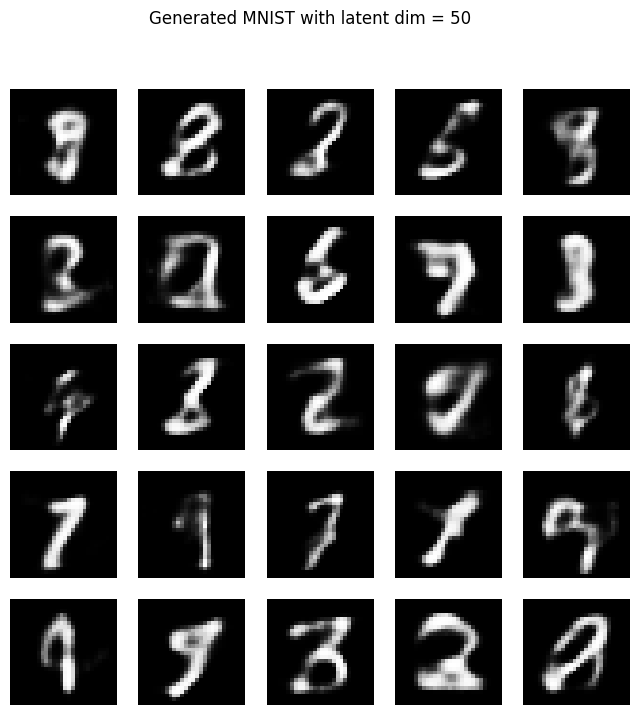

In [5]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

def generate_mnist(vae:VAE, file_name:str='generated_img.png'):
  transform = T.ToPILImage()
  col,row = 5,5
  full_size = col*row
  fig = plt.figure(figsize=(8,8))
  fig.suptitle(f"Generated MNIST with latent dim = {vae.latent_dim}")
  for i in range(full_size):
    ax = fig.add_subplot(row,col,i+1)
    tensor_img = sample_from_latent_space(vae)
    img = transform(tensor_img)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')
  fig.savefig(file_name)
  plt.show()

generate_mnist(vae)


Nous pouvons remarquer que le modèle peut générer des images de chiffres qui sont reconnaissables comme les 7 et les 9. Cependant ceci ne représente qu'une minorité sur les images générées. Certaines ont des formes incohérentes d'autres sont partiellement dessinées.

### Changer la dimension de l'espace latent.

Dans notre premier cas la dimension latente était de 50, nous allons la diminuer à  10 d'une part et augmenter à 100 d'autre part et observer la qualité des résultats générés mais aussi les loss respectives.

In [6]:
vae_10 = VAE(latent_dim=10)
vae_100 =  VAE(latent_dim=100)

for network in [vae_10,vae_100]:
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  train_vae(network,optimizer=optimizer,train_loader=train_loader,n_epochs=15)

  7%|▋         | 1/15 [00:11<02:39, 11.40s/it]

Epoch 0, Loss: 162.16032236328124


 13%|█▎        | 2/15 [00:22<02:28, 11.40s/it]

Epoch 1, Loss: 124.51645444335938


 20%|██        | 3/15 [00:34<02:16, 11.37s/it]

Epoch 2, Loss: 119.45734036458333


 27%|██▋       | 4/15 [00:45<02:05, 11.37s/it]

Epoch 3, Loss: 116.97094873046875


 33%|███▎      | 5/15 [00:56<01:53, 11.37s/it]

Epoch 4, Loss: 115.43853061523437


 40%|████      | 6/15 [01:08<01:42, 11.36s/it]

Epoch 5, Loss: 114.24364895833334


 47%|████▋     | 7/15 [01:19<01:31, 11.39s/it]

Epoch 6, Loss: 113.31542630208334


 53%|█████▎    | 8/15 [01:31<01:19, 11.39s/it]

Epoch 7, Loss: 112.6130541829427


 60%|██████    | 9/15 [01:42<01:08, 11.46s/it]

Epoch 8, Loss: 111.98460032552083


 67%|██████▋   | 10/15 [01:53<00:57, 11.41s/it]

Epoch 9, Loss: 111.44583629557292


 73%|███████▎  | 11/15 [02:05<00:45, 11.31s/it]

Epoch 10, Loss: 110.95478901367187


 80%|████████  | 12/15 [02:16<00:34, 11.34s/it]

Epoch 11, Loss: 110.524342578125


 87%|████████▋ | 13/15 [02:27<00:22, 11.38s/it]

Epoch 12, Loss: 110.0850270345052


 93%|█████████▎| 14/15 [02:39<00:11, 11.37s/it]

Epoch 13, Loss: 109.78365895182291


100%|██████████| 15/15 [02:50<00:00, 11.39s/it]


Epoch 14, Loss: 109.42076954752604


  7%|▋         | 1/15 [00:12<02:50, 12.16s/it]

Epoch 0, Loss: 173.41038377278645


 13%|█▎        | 2/15 [00:24<02:37, 12.09s/it]

Epoch 1, Loss: 131.58625563151043


 20%|██        | 3/15 [00:36<02:25, 12.08s/it]

Epoch 2, Loss: 120.2024649576823


 27%|██▋       | 4/15 [00:48<02:13, 12.11s/it]

Epoch 3, Loss: 114.3531964029948


 33%|███▎      | 5/15 [01:00<02:01, 12.14s/it]

Epoch 4, Loss: 111.5293040201823


 40%|████      | 6/15 [01:12<01:49, 12.19s/it]

Epoch 5, Loss: 109.77154329427083


 47%|████▋     | 7/15 [01:25<01:37, 12.21s/it]

Epoch 6, Loss: 108.63389205729166


 53%|█████▎    | 8/15 [01:37<01:25, 12.22s/it]

Epoch 7, Loss: 107.80258675130209


 60%|██████    | 9/15 [01:49<01:13, 12.22s/it]

Epoch 8, Loss: 107.16214453125


 67%|██████▋   | 10/15 [02:01<01:00, 12.20s/it]

Epoch 9, Loss: 106.61677711588541


 73%|███████▎  | 11/15 [02:13<00:48, 12.18s/it]

Epoch 10, Loss: 106.2574381998698


 80%|████████  | 12/15 [02:26<00:36, 12.17s/it]

Epoch 11, Loss: 105.93123828125


 87%|████████▋ | 13/15 [02:38<00:24, 12.17s/it]

Epoch 12, Loss: 105.67155255533854


 93%|█████████▎| 14/15 [02:50<00:12, 12.18s/it]

Epoch 13, Loss: 105.40504562174479


100%|██████████| 15/15 [03:02<00:00, 12.18s/it]

Epoch 14, Loss: 105.15708204752605


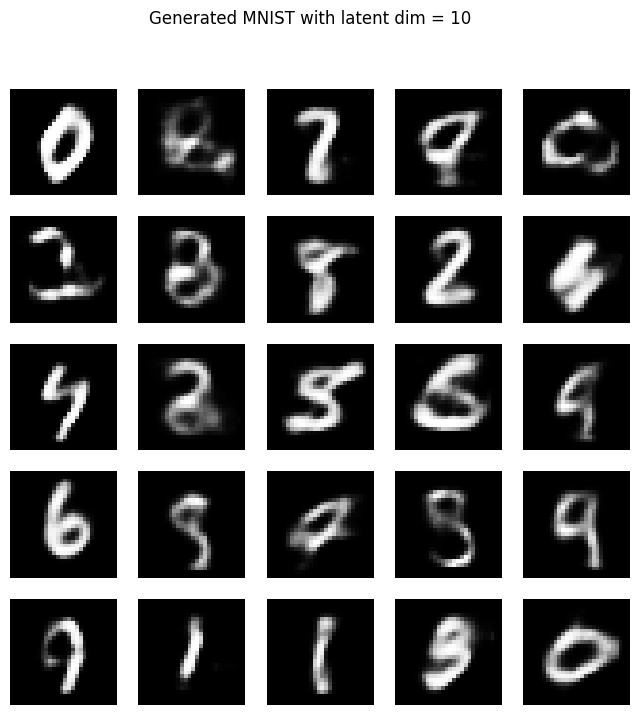

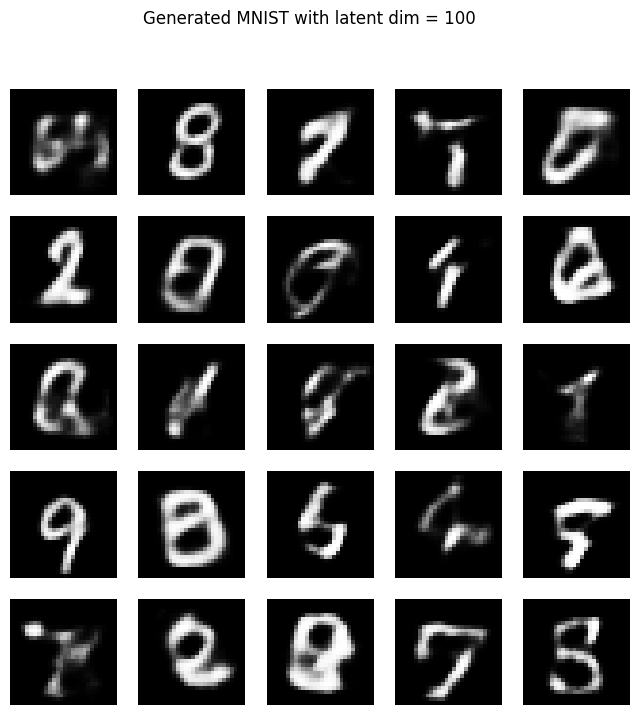

In [7]:
for network,name in zip([vae_10,vae_100],['VAE_10','VAE_100']):
  generate_mnist(network,f'{name}.png')

On remarque encore une fois que les données générées sont en majorité invraisemblables pour un humain. Notons toutefois que les chiffres 9, 7 et 1 sont reconnaissables par comparaison avec les autres.

### Changer L'architecture du VAE

L'auto-encodeur variationnel a besoin d'être adapté pour les images, il doit donc avoir des couches de convolution pour l'encodeur et le décodeur.

In [8]:
alt_train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)
next(iter(alt_train_loader))[0].shape

torch.Size([128, 1, 28, 28])

In [75]:
from torch import nn
import torch

class Encoder(nn.Module):
    def __init__(self, n_channel:int,latent_dim:int,width:int, height:int,fc_output:int=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.enc = nn.Sequential(
            nn.Conv2d(n_channel, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        enc_output = self.enc(torch.zeros(1,n_channel,width,height))
        enc_output = enc_output.view(enc_output.shape[0],-1)
        fc_input_size = enc_output.shape[1]
        self.fc = nn.Sequential(
            nn.Linear(fc_input_size, latent_dim),
            nn.ReLU(inplace=True)
        )
        self.fc_mean = nn.Linear(fc_output, latent_dim)
        self.fc_log_var = nn.Linear(fc_output, latent_dim)

    def forward(self, x):
        x = self.enc(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        epsilon = torch.randn_like(mean)
        z = mean + torch.exp(log_var) * epsilon

        return z, mean, log_var

sample = next(iter(alt_train_loader))[0]
encoder = Encoder(n_channel=sample.shape[1], latent_dim=50,width=sample.shape[2],height= sample.shape[2])
z, mean, log_var = encoder(sample)
z.shape, mean.shape, log_var.shape

RuntimeError: ignored

In [58]:
class Decoder(nn.Module):
  def __init__(self, latent_dim=2,fc_output:int=64,output_dim:int=784):
    super().__init__()

    self.fc = nn.Sequential(
        nn.Linear(latent_dim, fc_output),
        nn.ReLU(inplace=True)
    )
    self.fc_output = fc_output
    self.dec = nn.Sequential(
        nn.Linear(fc_output, output_dim),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.fc(x)
    x = self.dec(x)
    x = torch.sigmoid(x)
    return x
sample = next(iter(alt_train_loader))[0]
output_shape = sample.view(len(sample),-1).shape
print(output_shape)
latent_dim = 50
encoder = Encoder(n_channel=sample.shape[1], latent_dim=latent_dim,width=sample.shape[2],height= sample.shape[2])
z, mean, log_var = encoder(sample)
decoder = Decoder(latent_dim,fc_output=16)

assert decoder(z).shape == output_shape
print("Shapes are ok")

torch.Size([128, 784])
Shapes are ok


In [71]:
class AltVAE(nn.Module):
  def __init__(self,latent_dim:int,n_channel:int, width:int, height:int,fc_output:int=16):
    super(AltVAE, self).__init__()
    self.encode = Encoder(n_channel=n_channel,latent_dim=latent_dim,width=width,height=height,fc_output=fc_output)
    self.decode = Decoder(latent_dim,fc_output=16)
    self.latent_dim = latent_dim

  def forward(self, x):
    z, mean, log_var = self.encode(x)
    xhat = self.decode(z)
    return xhat, mean, log_var



my_vae = AltVAE(latent_dim,1,28,28,16)
xhat, mean, log_var = my_vae(sample)
output_shape = sample.view(len(sample),-1).shape
assert xhat.shape == output_shape
assert len(mean.shape) == 2 and mean.shape[1] == 50
assert len(log_var.shape) == 2 and log_var.shape[1] == 50
print("Les shapes du VAE sont cohérentes")

Les shapes du VAE sont cohérentes


### Paramétrer la fonction loss pour pondérer les deux termes

Nous allons créer une fonction de loss qui puisse apprendre à paramétrer la pondération des deux termes

In [72]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return self.alpha * BCE + self.beta * KLD


In [73]:
optimizer = torch.optim.Adam(my_vae.parameters(), lr=1e-3)
loss_func = CustomLoss()
n_epochs =10
for epoch in tqdm(range(n_epochs)):
      my_vae.train()
      train_loss = 0
      for data, _ in train_loader:
          data = data.to(device)

          optimizer.zero_grad()
          recon_batch, mu, logvar = my_vae(data)
          loss = loss_func(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

      print(f'Epoch {epoch}, Loss: {train_loss / len(alt_train_loader.dataset)}')


 10%|█         | 1/10 [00:16<02:28, 16.44s/it]

Epoch 0, Loss: 546.6992744791667


 20%|██        | 2/10 [00:33<02:14, 16.75s/it]

Epoch 1, Loss: 543.4210123046875


 30%|███       | 3/10 [00:49<01:55, 16.56s/it]

Epoch 2, Loss: 543.4128880859375


 40%|████      | 4/10 [01:06<01:38, 16.46s/it]

Epoch 3, Loss: 543.4115083984375


 50%|█████     | 5/10 [01:23<01:23, 16.65s/it]

Epoch 4, Loss: 543.4117856770833


 60%|██████    | 6/10 [01:39<01:06, 16.53s/it]

Epoch 5, Loss: 543.4110121744792


 70%|███████   | 7/10 [01:55<00:49, 16.47s/it]

Epoch 6, Loss: 543.4108828125


 80%|████████  | 8/10 [02:12<00:33, 16.65s/it]

Epoch 7, Loss: 543.4108633463542


 90%|█████████ | 9/10 [02:28<00:16, 16.53s/it]

Epoch 8, Loss: 543.4106832682291


100%|██████████| 10/10 [02:45<00:00, 16.53s/it]

Epoch 9, Loss: 543.4104616536458


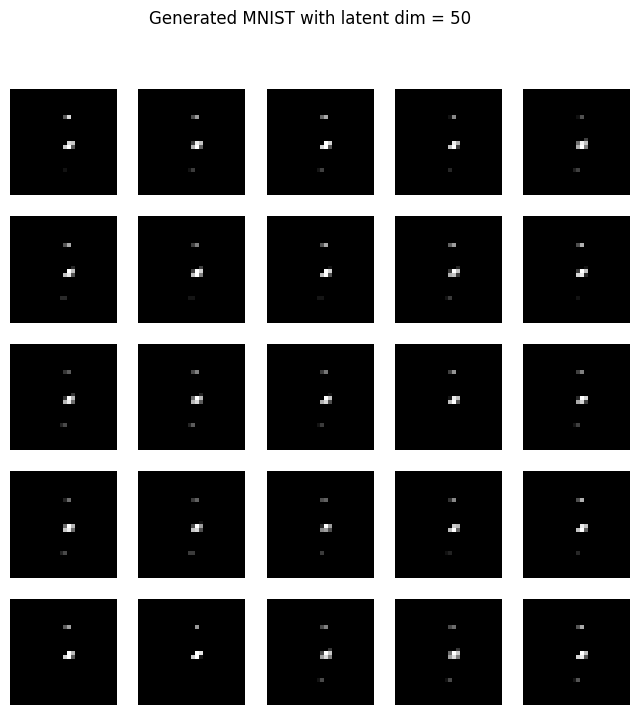

In [74]:
generate_mnist(my_vae,file_name='self_vae.png')